**Brief Honor Code**. Do the homework on your own. You may discuss ideas with your classmates, but DO NOT copy the solutions from someone else or the Internet. If stuck, discuss with TA.

**1**. (10 points) 

Rewrite the following code into functional form using lambdas, map, filter and reduce.

In [1]:
n = 10
s = 10
for i in range(n):
    if i % 2:
        s |= i**2
s

123

In [2]:
from functools import reduce
from operator import or_

In [3]:
n = 10
reduce(or_, map(lambda x: x**2, filter(lambda i: i %2, range(n))), 10)

123

**2**. (10 points)

Rewrite the code above as a `toolz` pipeline, using lambdas and curried or partially applied functions as necessary.

In [4]:
import toolz as tz
import toolz.curried as c

In [5]:
n = 10
s = 10
tz.pipe(
    range(n),
    c.filter(lambda i: i % 2),
    c.map(lambda x: x**2),
    lambda x: c.reduce(or_, x, s)
)

123

#### Alternative

In [6]:
n = 10
s = 10
tz.pipe(
    range(n),
    c.filter(lambda i: i%2),
    c.map(lambda x: x**2),
    tz.flip(c.reduce(or_))(s)
)

123

**3**. (10 points) 

Repeat the Buffon's needle simulation from Lab01 as a function that takes the number of needels `n` as input and returns the estimate of $\pi$. The function should use `numpy` and vectorization. 

In [7]:
import numpy as np

def buffon(n):
    """Estimate pi using Buffon's needle simulation for n needels."""
    
    y = np.random.random(n)
    theta = np.random.uniform(0, np.pi, n)
    upper = y + 0.5*np.sin(theta)
    lower = y - 0.5*np.sin(theta)
    p = np.sum(np.where((lower < 0) | (upper > 1), 1, 0))/n
    pi = 2/p
    return pi

In [8]:
buffon(int(1e6))

3.1383133135096544

**4**. (20 points) 

Simpsons rule is given by the follwoing approximation

![Simpsons](https://wikimedia.org/api/rest_v1/media/math/render/svg/a0cdf0804bb8810e4438cbea898dc7a2fedb3e57)

- Write Simpsons rule as a function `simpsons(f, a, b, n=100)` where n is the number of equally spaced intervals from `a` to `b`.  (10 points)
- Use this function to estimate the probability mass of the standard normal distribution between -1 and 1. Implement the PDF of the standard normal distribution $\psi(x)$ as a function. (10 points)

$$
\psi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}
$$

In [9]:
def simpsons(f, a, b, n=100):
    """Simpson's rule."""
    
    x = np.linspace(a, b, n+1)
    h = (b-a)/n
    return (h/3)*(f(x[0]) + 2*np.sum(f(x[2:-1:2])) + 4*np.sum(f(x[1::2])) + f(x[-1]))

In [10]:
def standard_normal_pdf(x):
    """PDF of standard normal distribution."""
    
    return 1.0/np.sqrt(2*np.pi) * np.exp(-x**2/2)

In [11]:
simpsons(standard_normal_pdf, -1, 1)

0.6826894929975491

**5**. (50 points)

Write code to generate a plot similar to the following 

![automata](figs/automata1d.png)

using the explanation for generation of 1D Cellular Automata found [here](http://mathworld.wolfram.com/ElementaryCellularAutomaton.html). You should only need to use standard Python, `numpy` and `matplotllib`.

The input to the function making the plots should be a simple list of rules

```python
rules = [30, 54, 60, 62, 90, 94, 102, 110, 122, 126, 
         150, 158, 182, 188, 190, 220, 222, 250]
make_plots(rules, niter, ncols)
```

You may, of course, write other helper functions to keep your code modular.

In [12]:
import numpy as np

In [13]:
def make_map(rule):
    """Convert an integer into a rule mapping nbr states to new state."""
    bits = map(int, list(bin(rule)[2:].zfill(8)))
    return dict(zip(range(7, -1, -1), bits))

In [14]:
def make_ca(rule, init, niters):
    """Run a 1d CA from init state for niters for given rule."""
    
    mapper = make_map(rule)
    grid = np.zeros((niters, len(init)), 'int')
    grid[0] = init
    old = np.r_[init[-1:], init, init[0:1]]
    for i in range(1, niters):
        nbrs = zip(old[0:], old[1:], old[2:])
        cells = (int(''.join(map(str, nbr)), base=2) for nbr in nbrs)
        new = np.array([mapper[cell] for cell in cells])
        grid[i] = new
        old = np.r_[new[-1:], new, new[0:1]]
    return grid

#### Alternative version

In [15]:
def to_binary(n, width):
    """Returns vector of size=width containing binnary represention of n."""
    assert(n < 2**width)
    
    xs = np.zeros(width, int)
    for i in range(width):
        n, m = n // 2, n % 2 # or divmod(n, 2)
        xs[width-i-1] = m
    return xs

def make_map_alt(rule):
    """Convert an integer into a rule mapping nbr states to new state."""
    
    bits = to_binary(rule, 8)[::-1]
    nbrs = [tuple(to_binary(i, 3)) for i in range(8)]
    return dict(zip(nbrs, bits))

def make_ca_alt(rule, init, niters):
    """Run a 1d CA from init state for niters for given rule."""
    
    mapper = make_map_alt(rule)
    grid = np.zeros((niters, 2+len(init)), 'int')
    grid[0, 1:-1] = init
    for i in range(1, niters):
        nbrs = zip(grid[i-1, 0:], grid[i-1, 1:], grid[i-1, 2:])
        grid[i, 1:-1] = [mapper[nbr] for nbr in nbrs]
    return grid[:, 1:-1]

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, IndexLocator

In [17]:
def plot_grid(rule, grid, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    ax.imshow(grid, interpolation='none', cmap='Greys', aspect=1, alpha=0.8)
    ax.set_title('Rule %d' % rule)
    
    # Code below is nice to have to make the plot prettier
    ax.grid(True, which='major', color='grey', linewidth=0.5)
    ax.xaxis.set_major_locator(IndexLocator(1, 0))
    ax.yaxis.set_major_locator(IndexLocator(1, 0))
    ax.xaxis.set_major_formatter( NullFormatter() )
    ax.yaxis.set_major_formatter( NullFormatter() )
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

In [18]:
def make_plots(rules, niter, ncols, builder=make_ca):
    """Make a plot of Wolfram automata from rules."""

    width = niter*2+1
    init = np.zeros(width, 'int')
    init[width//2] = 1

    nrows = (len(rules)+ncols-1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2))
    for i in range(nrows):
        for j in range(ncols):
            grid = builder(rules[i*ncols+j], init, niter)
            plot_grid(rules[i*ncols + j], grid, ax=axes[i,j])
    plt.tight_layout()

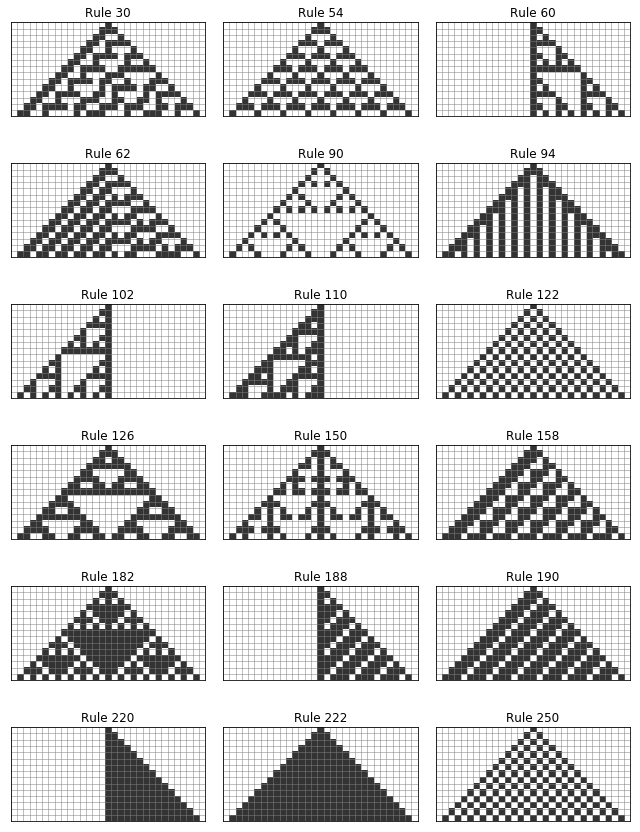

In [19]:
rules = [30, 54, 60, 62, 90, 94, 102, 110, 122, 126, 
         150, 158, 182, 188, 190, 220, 222, 250]
niter = 15
ncols = 3
make_plots(rules, niter, ncols)

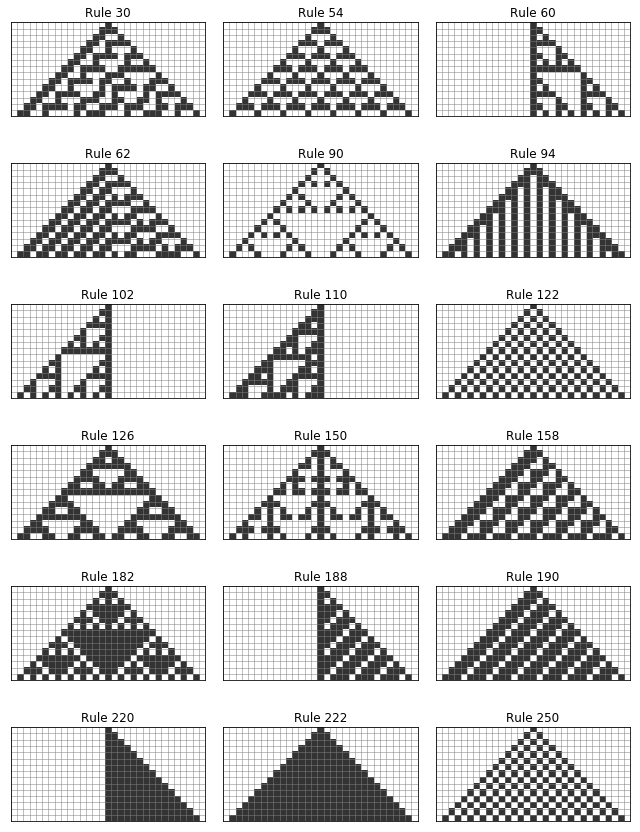

In [20]:
make_plots(rules, niter, ncols, builder=make_ca_alt)